# Mixture Model (Coffees dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import sys, IPython, matplotlib, platform
print("This notebook was created on a %s computer running %s using:\nPython v%s\nIPython \
v%s\nPyMC3 v%s\nNumPy v%s\nMatplotlib v%s\nSeaborn v%s\nPandas v%s\nArviz v%s" % (platform.machine(), \
' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, \
np.__version__, matplotlib.__version__, sns.__version__, pd.__version__, az.__version__))

This notebook was created on a x86_64 computer running Ubuntu 18.04 using:
Python v3.6.8
IPython v7.8.0
PyMC3 v3.7
NumPy v1.17.3
Matplotlib v3.1.1
Seaborn v0.9.0
Pandas v0.25.2
Arviz v0.5.1


In [3]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Load raw data and plot

In [4]:
# init data object
data_obj = Data('../../data/coffees/FTIR_instant_coffees.csv', 'label', -2)
data = data_obj.data
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
5,13.165349,13.587405,13.998584,13.476876,12.577613,11.989945,11.243600,10.692459,10.469784,10.374012,...,2.044999,2.023647,2.008715,1.990087,1.965167,1.953658,1.942450,1.930312,1,Arabica
33,14.108081,14.476337,14.516783,14.074631,13.217934,12.466894,11.724800,11.070709,10.706896,10.565004,...,1.896521,1.876392,1.852087,1.830727,1.813216,1.798814,1.783991,1.776107,2,Robusta
13,13.438294,13.687354,14.090918,13.742180,12.870400,12.025635,11.451002,11.097792,10.680395,10.490485,...,2.128728,2.106235,2.090319,2.074972,2.056196,2.039637,2.026209,2.019408,1,Arabica
19,11.708212,12.189027,12.115101,11.461263,10.624787,9.845979,9.528569,9.187627,8.901355,8.872402,...,1.934408,1.914148,1.901100,1.887963,1.871052,1.855958,1.838835,1.827901,1,Arabica


Arabica: blue
Robusta: red


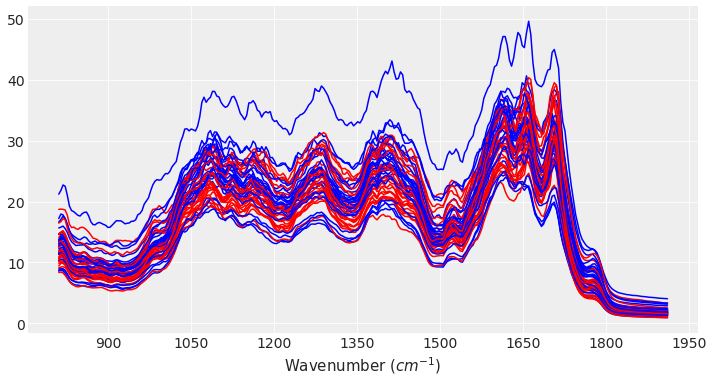

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 50)

In [6]:
# number of samples from each class
data[data_obj.label_column].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [7]:
# 1D array containing class codes
Y = np.array(pd.Categorical(data[data_obj.label_column]).codes, dtype='int')

# number of classes
nclass = data_obj.classes

# data array
x_n = data.columns[:data_obj.non_data_columns]
x_s = data[x_n].values
x_s.shape

(56, 286)

# Model definition

The following statistical model is assumed:

\begin{equation}
\mu_x \sim U(0, max(Y)) \\
\sigma_{s} \sim \Gamma(1, 1) \\
\sigma_{x} \sim |\mathcal{N}(0, \sigma^{2}_{s})| \\
X_0 \sim \mathcal{N}(\mu_x,\,\sigma^{2}_{x}) \\
X_1 \sim \mathcal{N}(\mu_x,\,\sigma^{2}_{x}) \\
\sigma_{\epsilon} \sim \Gamma(1, 1) \\
\epsilon_{x} \sim |\mathcal{N}(0,\,\sigma^{2}_{\epsilon})| \\
\theta \sim Beta(1,1) \\
Y \sim Bernoulli(\theta) \\
X = \begin{cases}X_0 + \epsilon_x & \text{if } Y = 0 \\X_1 + \epsilon_x & \text{if } Y = 1\end{cases}
\end{equation}

In [8]:
# 2D array containing class labels for each observation
Yl = np.full((len(x_s), len(x_n)), 0)
for i in range(len(x_s)):
    if (Y[i] == 1):
        Yl[i,:] = 1
    else:
        Yl[i,:] = 0

In [10]:
with pm.Model() as model_mm:
    mu_x = pm.Uniform('mu_x', 0, x_s.max())
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma_x = pm.HalfNormal('sigma_x', sigma_s)
    #x = pm.Normal('x', mu=mu_x, sd=sigma_x, shape=(nclass,len(x_n)))
    x_0 = pm.Normal('x_0', mu=mu_x, sd=sigma_x, shape=len(x_n))
    x_1 = pm.Normal('x_1', mu=mu_x, sd=sigma_x, shape=len(x_n))
    
    # labels 0 or 1 (observed from the data)
    theta = pm.Beta('theta', 1, 1)
    label = pm.Bernoulli('label', p=theta, observed=Yl) 
    
    # switch to spectrum 0 or 1 depending on class
    #X = pm.math.switch(pm.math.eq(label, 1), x[0], x[1])
    X = pm.math.switch(pm.math.eq(label, 1), x_0, x_1)
    
    # random noise on top of observation
    sigma_e = pm.Gamma('sigma_e', alpha=1., beta=1.)
    epsilon_x = pm.HalfNormal('epsilon_x', sigma_e)
    
    y_pred = pm.Normal('y_pred', mu=X, sd=epsilon_x, observed=x_s)
    
    trace_mm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon_x, sigma_e, theta, x_1, x_0, sigma_x, sigma_s, mu_x]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:11<00:00, 69.94draws/s] 


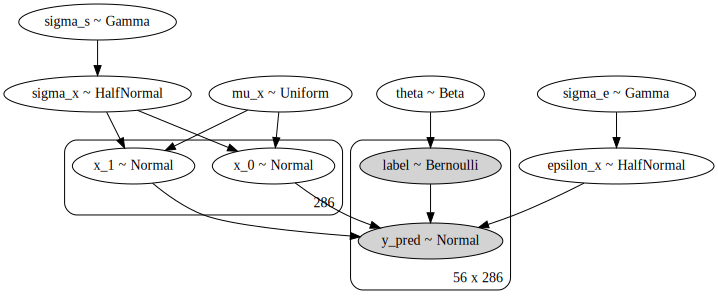

In [11]:
pm.model_to_graphviz(model_mm)

In [12]:
az.summary(trace_mm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x_0[0],11.989,0.644,10.824,13.195,0.006,0.005,9917.0,9819.0,9912.0,2521.0,1.0
x_0[1],12.282,0.653,11.008,13.426,0.007,0.005,8598.0,8598.0,8630.0,2439.0,1.0
x_0[2],12.258,0.624,11.047,13.360,0.006,0.004,9984.0,9984.0,9987.0,2561.0,1.0
x_0[3],11.869,0.630,10.707,13.062,0.006,0.004,12378.0,12097.0,12358.0,2680.0,1.0
x_0[4],11.188,0.620,10.055,12.388,0.007,0.005,7609.0,7495.0,7606.0,2784.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
sigma_s,4.369,1.257,2.371,6.721,0.015,0.013,7111.0,4688.0,10702.0,2465.0,1.0
sigma_x,8.152,0.247,7.678,8.600,0.003,0.002,8346.0,8192.0,8419.0,2663.0,1.0
theta,0.482,0.004,0.475,0.490,0.000,0.000,9817.0,9817.0,9843.0,2405.0,1.0
sigma_e,2.516,0.966,1.083,4.309,0.013,0.011,5289.0,3592.0,8626.0,2501.0,1.0


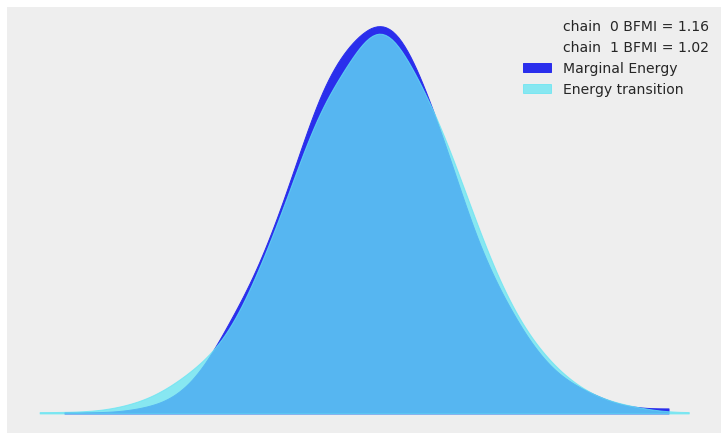

In [13]:
az.plot_energy(trace_mm, figsize=(10, 6));

In [14]:
ppc = pm.sample_posterior_predictive(trace_mm, samples=250, model=model_mm)

100%|██████████| 250/250 [00:00<00:00, 254.34it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


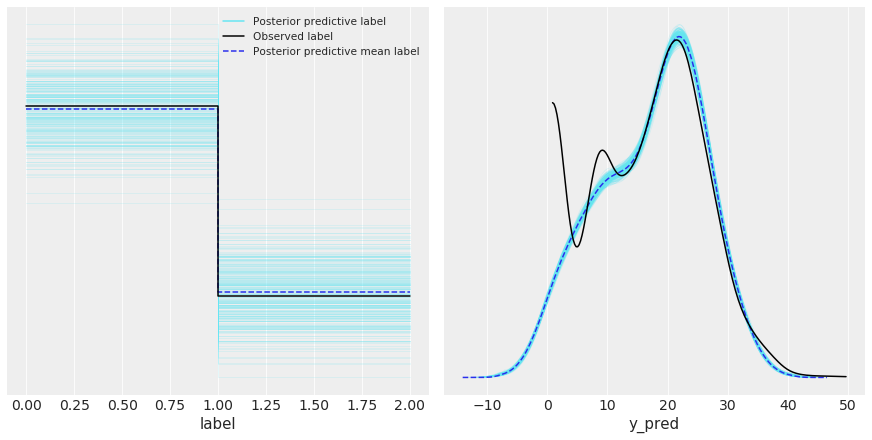

In [15]:
data_ppc = az.from_pymc3(trace=trace_mm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [16]:
az.r2_score(x_s, ppc['y_pred'])

r2        0.847109
r2_std    0.014138
dtype: float64

In [17]:
print(az.bfmi(trace_mm))

[1.15923254 1.01650242]


In [18]:
#print(az.loo(trace_mm))

In [19]:
#print(az.waic(trace_mm))

# Posterior samples vs. mean data

In [22]:
# class samples from the posterior
cl_a = ppc['y_pred']

ppc_class_lst = [cl_a]

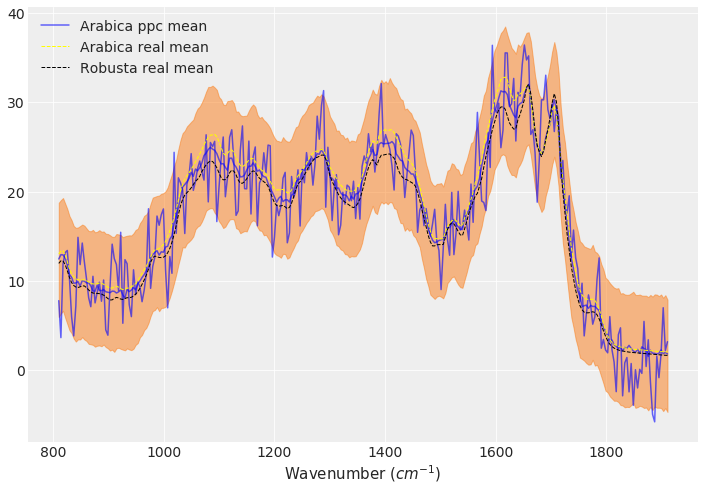

In [23]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

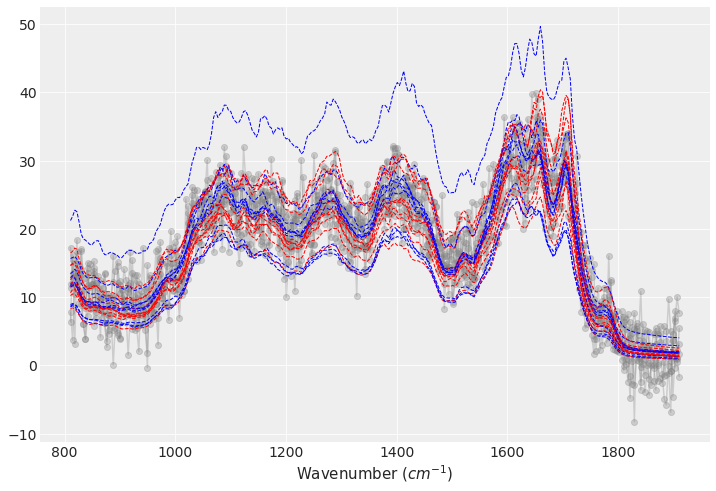

In [24]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 10)